In [1]:
KAGGLE_UPLOAD = False

if KAGGLE_UPLOAD:
    # /content/ 폴더에 kaggle.json을 업로드 (매번 colab노트북 생성시 반복)
    from google.colab import files
    files.upload()
else:
    kaggle_username = 'ventureparker'
    from google.colab import userdata
    kaggle_key = userdata.get(kaggle_username)

In [2]:
import json
import os

def create_kaggle_json(username, key, file_path):
    # 데이터 생성
    kaggle_data = {
        "username": username,
        "key": key
    }

    # JSON 파일로 저장
    with open(file_path, 'w') as json_file:
        json.dump(kaggle_data, json_file)

    print(f"kaggle.json 파일이 '{os.path.abspath(file_path)}' 경로에 생성되었습니다.")



# kaggle.json 파일 생성 함수 호출
if KAGGLE_UPLOAD==False:
    # 사용자 정보 입력
    key = kaggle_key  # 여기에 key값을 입력하세요
    filename = 'kaggle.json'
    create_kaggle_json(kaggle_username, key, filename)

kaggle.json 파일이 '/content/kaggle.json' 경로에 생성되었습니다.


In [4]:
import os
import shutil

os.makedirs('/root/.kaggle', exist_ok=True)
path = os.getcwd()

# 파일을 복사하는데, 이미 복사된 경우 복사하지 않는다.
if not os.path.exists(os.path.join('/root/.kaggle','kaggle.json')):
    src = os.path.join(path,'kaggle.json')
    dst = os.path.join('/root/.kaggle', 'kaggle.json')
    shutil.copy(src,dst)
    print('파일 복사 완료')

파일 복사 완료


In [6]:
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
100% 346M/346M [00:06<00:00, 29.0MB/s]
100% 346M/346M [00:06<00:00, 53.0MB/s]


In [7]:
!unzip -qq intel-image-classification.zip -d /content/dataset/

In [8]:
!ls dataset

seg_pred  seg_test  seg_train


In [9]:
# train데이터를 8:2로 나눠서 train:valid
# pred데이터를 test데이터로 사용

In [10]:
import os

dataPath = '/content/dataset/'
trainPath = os.path.join(dataPath, 'seg_train/seg_train/')
testPath = os.path.join(dataPath, 'seg_test/seg_test/')

In [11]:
folderList = os.listdir(trainPath)
for folder in folderList:
    currentDir = os.path.join(trainPath,folder)
    print(len(os.listdir(currentDir)))

2382
2271
2274
2191
2404
2512


In [12]:
import random

train_ratio = 0.8
valid_ratio = 0.2

# validPath를 지정
validPath = os.path.join(dataPath,'seg_valid')

# 모든 폴더 8:2 나누는 것을 구현
import shutil

if not os.path.exists(validPath):
    # validPath 폴더를 생성
    os.makedirs(validPath, exist_ok=True)

    folderList = os.listdir(trainPath)
    for folder in folderList:
        currentDir = os.path.join(trainPath,folder)
        # 현재 폴더의 파일 목록, 갯수
        fileList = os.listdir(currentDir)
        dataCount = len(fileList)
        validCount = int(dataCount * valid_ratio)
        # validPath의 클래스 폴더를 생성
        os.makedirs(os.path.join(validPath,folder), exist_ok=True)

        # 파일 리스트에서 랜덤하게 validCount만큼 선택해서 validList 생성
        validList = random.sample(fileList, validCount)
        for validFile in validList:
            oldPath = os.path.join(currentDir, validFile)
            newPath = os.path.join(validPath, folder, validFile)
            #print(oldPath, newPath)
            shutil.move(oldPath, newPath)


In [13]:
folderList = os.listdir(validPath)
for folder in folderList:
    currentDir = os.path.join(validPath,folder)
    print(len(os.listdir(currentDir)))

476
454
454
438
480
502


## 데이터가 준비 되었으니 ResNet50.ipynb내용 적용

In [14]:
import torch
import torchvision
import torchvision.models as models
from torchvision.models import ResNet50_Weights
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np
import pandas as pd

In [15]:
data_dir = '/content/dataset'

In [16]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [51]:
train_data = ImageFolder(root=f"{data_dir}/seg_train/seg_train", transform=train_transform)
valid_data = ImageFolder(root=f"{data_dir}/seg_valid", transform=test_transform)
test_data = ImageFolder(root=f"{data_dir}/seg_test/seg_test", transform=test_transform)

# train_size = int(0.8 * len(train_data))
# val_size = len(train_data) - train_size
# train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(valid_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [52]:
class ModifiedResNet50(nn.Module):
    def __init__(self):
        super(ModifiedResNet50, self).__init__()
        self.base_model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_ftrs, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, 6)

    def forward(self, x):
        x = self.base_model(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [60]:
model = ModifiedResNet50()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

results = []

In [63]:
for images, labels in train_loader:
    print(labels.shape)


torch.Size([64])


In [61]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_loss, val_acc, val_f1, _, _ = evaluate_model(model, val_loader)
        results.append({
            'epoch': epoch + 1,
            'train_loss': running_loss / len(train_loader),
            'val_loss': val_loss,
            'val_accuracy': val_acc,
            'val_f1_score': val_f1
        })
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss}, Val Accuracy: {val_acc}%, Val F1-Score: {val_f1}")

def evaluate_model(model, data_loader):
    model.eval()
    total = 0
    correct = 0
    loss_total = 0
    all_targets = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss_total += loss.item()
            all_targets.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    val_loss = loss_total / len(data_loader)
    val_acc = 100 * correct / total
    val_f1 = f1_score(all_targets, all_preds, average='macro')
    return val_loss, val_acc, val_f1, all_preds, all_targets

In [62]:
# 학습 진행
train_model(model, criterion, optimizer, num_epochs=10)

100%|██████████| 176/176 [02:35<00:00,  1.13it/s]


Epoch 1, Loss: 0.4004149458540434, Val Loss: 0.18636939420618795, Val Accuracy: 93.509272467903%, Val F1-Score: 0.9363997559480793


100%|██████████| 176/176 [02:33<00:00,  1.15it/s]


Epoch 2, Loss: 0.17909066980196672, Val Loss: 0.1732295738025145, Val Accuracy: 93.79457917261055%, Val F1-Score: 0.9393161687994427


100%|██████████| 176/176 [02:33<00:00,  1.15it/s]


Epoch 3, Loss: 0.13609969728118318, Val Loss: 0.16741998984732412, Val Accuracy: 94.04422253922966%, Val F1-Score: 0.9414760491899316


100%|██████████| 176/176 [02:41<00:00,  1.09it/s]


Epoch 4, Loss: 0.10403331499335101, Val Loss: 0.19697464037347923, Val Accuracy: 93.72325249643367%, Val F1-Score: 0.9383037611142427


100%|██████████| 176/176 [02:35<00:00,  1.13it/s]


Epoch 5, Loss: 0.07972686517115851, Val Loss: 0.18895369192416017, Val Accuracy: 93.97289586305278%, Val F1-Score: 0.9408007352032913


100%|██████████| 176/176 [02:34<00:00,  1.14it/s]


Epoch 6, Loss: 0.0633593041963071, Val Loss: 0.22130821315063673, Val Accuracy: 93.72325249643367%, Val F1-Score: 0.9382170660533359


100%|██████████| 176/176 [02:33<00:00,  1.14it/s]


Epoch 7, Loss: 0.05539389505230991, Val Loss: 0.2539971401724456, Val Accuracy: 93.54493580599144%, Val F1-Score: 0.9368351622760259


100%|██████████| 176/176 [02:33<00:00,  1.15it/s]


Epoch 8, Loss: 0.04789686082618904, Val Loss: 0.23764306988397782, Val Accuracy: 94.11554921540656%, Val F1-Score: 0.9424780252295221


100%|██████████| 176/176 [02:33<00:00,  1.14it/s]


Epoch 9, Loss: 0.04166410632420924, Val Loss: 0.22074070416221564, Val Accuracy: 94.18687589158345%, Val F1-Score: 0.9429691861107857


100%|██████████| 176/176 [02:35<00:00,  1.13it/s]


Epoch 10, Loss: 0.03415242270090279, Val Loss: 0.23906212266195903, Val Accuracy: 94.18687589158345%, Val F1-Score: 0.9428350342626448


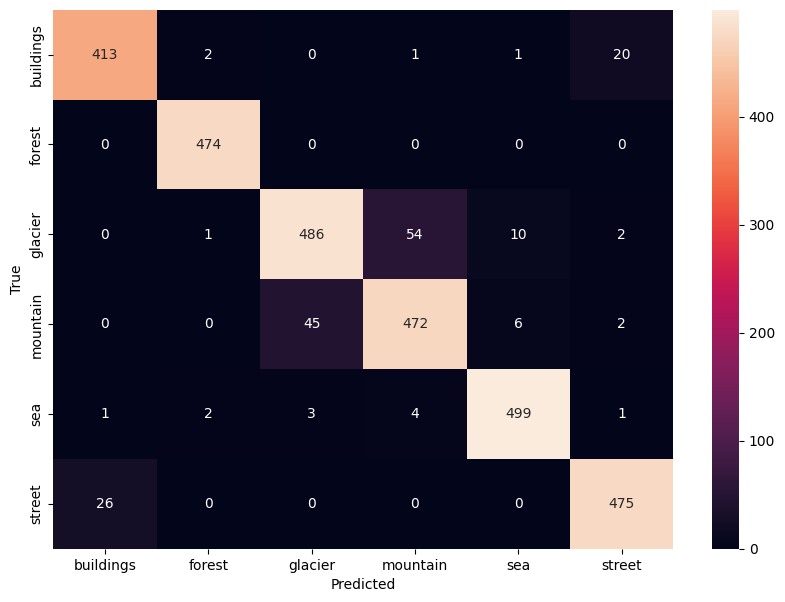

In [64]:
def plot_confusion_matrix(labels, predictions, class_names):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

_, _, _, preds, labels = evaluate_model(model, test_loader)
plot_confusion_matrix(labels, preds, train_data.classes)

In [25]:
!nvidia-smi

Mon Sep 30 08:15:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0              31W /  70W |   6243MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--